<a href="https://colab.research.google.com/github/WeizmannML/course2020/blob/master/Tutorial6/DGCNN_PointNet_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import glob
import h5py
import numpy as np
 
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
 
from torch.utils.data import Dataset
 
from torch.utils.data import DataLoader
import sklearn.metrics as metrics

### Building the loss function

In [0]:
def cal_loss(pred, gold, smoothing=True):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.2
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum(dim=1).mean()
    else:
        loss = F.cross_entropy(pred, gold, reduction='mean')

    return loss


class IOStream():
    def __init__(self, path):
        self.f = open(path, 'a')

    def cprint(self, text):
        print(text)
        self.f.write(text+'\n')
        self.f.flush()

    def close(self):
        self.f.close()

## Taken from : https://github.com/WangYueFt/dgcnn

## Building the dataset

In [0]:
!pwd

/content


In [0]:
def download():
    BASE_DIR = os.path.dirname(os.path.abspath(''))
    DATA_DIR = os.path.join(BASE_DIR, 'data')
    if not os.path.exists(DATA_DIR):
        os.mkdir(DATA_DIR)
    if not os.path.exists(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048')):
        www = 'https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip'
        zipfile = os.path.basename(www)
        os.system('wget %s; unzip %s' % (www, zipfile))
        os.system('mv %s %s' % (zipfile[:-4], DATA_DIR))
        os.system('rm %s' % (zipfile))


def load_data(partition):
    download()
    BASE_DIR = os.path.dirname(os.path.abspath(''))
    DATA_DIR = os.path.join(BASE_DIR, 'data')
    all_data = []
    all_label = []
    for h5_name in glob.glob(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048', 'ply_data_%s*.h5'%partition)):
        f = h5py.File(h5_name)
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        f.close()
        all_data.append(data)
        all_label.append(label)
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)
    return all_data, all_label


In [0]:
def translate_pointcloud(pointcloud):
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])
       
    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')
    return translated_pointcloud


def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    N, C = pointcloud.shape
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)
    return pointcloud


class ModelNet40(Dataset):
    def __init__(self, num_points, partition='train'):
        self.data, self.label = load_data(partition)
        self.num_points = num_points
        self.partition = partition        

    def __getitem__(self, item):
        pointcloud = self.data[item][:self.num_points]
        label = self.label[item]
        if self.partition == 'train':
            pointcloud = translate_pointcloud(pointcloud)
            np.random.shuffle(pointcloud)
        return pointcloud, label

    def __len__(self):
        return self.data.shape[0]

In [0]:
 train_data = ModelNet40(num_points=1024, partition='train')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [0]:
train_data

In [0]:
# for data, label in train_data:
#         print(data.shape)
#         print(label.shape)

In [0]:
x = train_data.__getitem__(15)
x

(array([[ 0.08361112, -0.5475652 , -0.3821683 ],
        [ 0.08993367, -0.01596269, -0.7354205 ],
        [-0.01592944,  1.2369236 ,  0.35338926],
        ...,
        [ 0.32140487, -0.6855519 ,  0.36844307],
        [ 0.12912914, -0.55360466, -0.23962341],
        [ 0.1462023 , -0.07317858, -0.41695237]], dtype=float32), array([8]))

In [0]:
points = x[0]

In [0]:
np.max(x[0]), np.min(x[0])

(1.3356407, -0.98063457)

In [0]:
points.shape

(1024, 3)

In [0]:
points[:,0].shape

(1024,)

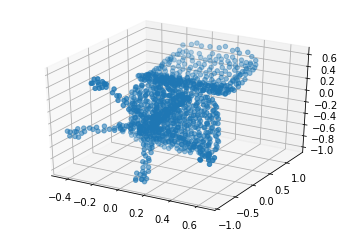

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(points[:,0], points[:,1], points[:,2], marker='o')

In [0]:
train_loader = DataLoader(ModelNet40(partition='train', num_points=1024), num_workers=0,
                          batch_size=10, shuffle=True, drop_last=True)
test_loader = DataLoader(ModelNet40(partition='test', num_points=1024), num_workers=0,
                          batch_size=10, shuffle=True, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


## Processing the pointcloud to image

In [0]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx
 
 
def get_graph_feature(x, k=20, idx=None):
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)
    device = torch.device('cuda')
 
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points
 
    idx = idx + idx_base
 
    idx = idx.view(-1)
 
    _, num_dims, _ = x.size()
 
    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims) 
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    
    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()
  
    return feature

## The DGCNN model

In [0]:
class DGCNN(nn.Module):
    def __init__(self, output_channels=40):
        super(DGCNN, self).__init__()

        emb_dims = 1024
        dropout = 0.5
        #self.args = args
        self.k = 20
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.linear1 = nn.Linear(emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=dropout)
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
model = DGCNN().to(device)

In [0]:
#model = nn.DataParallel(model)
print("Let's use", torch.cuda.device_count(), "GPUs!")

Let's use 1 GPUs!


In [0]:
opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [0]:
scheduler = CosineAnnealingLR(opt, 100, eta_min=0.001)
    
criterion = cal_loss

In [0]:
best_test_acc = 0
for epoch in range(100):
        scheduler.step()
        ####################
        # Train
        ####################
        train_loss = 0.0
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            opt.zero_grad()
            logits = model(data)
            loss = criterion(logits, label)
            loss.backward()
            opt.step()
            preds = logits.max(dim=1)[1]
            count += batch_size
            train_loss += loss.item() * batch_size
            train_true.append(label.cpu().numpy())
            train_pred.append(preds.detach().cpu().numpy())
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                                 train_loss*1.0/count,
                                                                                 metrics.accuracy_score(
                                                                                     train_true, train_pred),
                                                                                 metrics.balanced_accuracy_score(
                                                                                     train_true, train_pred))
        print(outstr)
        #io.cprint(outstr)

        ####################
        # Test
        ####################
        test_loss = 0.0
        count = 0.0
        model.eval()
        test_pred = []
        test_true = []
        for data, label in test_loader:
            data, label = data.to(device), label.to(device).squeeze()
            data = data.permute(0, 2, 1)
            batch_size = data.size()[0]
            logits = model(data)
            loss = criterion(logits, label)
            preds = logits.max(dim=1)[1]
            count += batch_size
            test_loss += loss.item() * batch_size
            test_true.append(label.cpu().numpy())
            test_pred.append(preds.detach().cpu().numpy())
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        test_acc = metrics.accuracy_score(test_true, test_pred)
        avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
        outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                              test_loss*1.0/count,
                                                                              test_acc,
                                                                              avg_per_class_acc)
        #io.cprint(outstr)
        print(outstr)
        # if test_acc >= best_test_acc:
        #     best_test_acc = test_acc
        #     torch.save(model.state_dict(), 'checkpoints/%s/models/model.t7' % 'Adam_test')


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train 0, loss: 2.541789, train acc: 0.505081, train avg acc: 0.315942
Test 0, loss: 2.107233, test acc: 0.657212, test avg acc: 0.529564
Train 1, loss: 2.099372, train acc: 0.680589, train avg acc: 0.524772
Test 1, loss: 1.833296, test acc: 0.797002, test avg acc: 0.700413
Train 2, loss: 1.998784, train acc: 0.731707, train avg acc: 0.590911
Test 2, loss: 1.775175, test acc: 0.813614, test avg acc: 0.705116
Train 3, loss: 1.924356, train acc: 0.766057, train avg acc: 0.643299
Test 3, loss: 1.761728, test acc: 0.814425, test avg acc: 0.721686
Train 4, loss: 1.891467, train acc: 0.774492, train avg acc: 0.654114
Test 4, loss: 1.694749, test acc: 0.850081, test avg acc: 0.752971
Train 5, loss: 1.861726, train acc: 0.789939, train avg acc: 0.676713
Test 5, loss: 1.688580, test acc: 0.861021, test avg acc: 0.773436
Train 6, loss: 1.835222, train acc: 0.803455, train avg acc: 0.697424
Test 6, loss: 1.707789, test acc: 0.854943, test avg acc: 0.783320
Train 7, loss: 1.808027, train acc: 0.813